## Dataset

In [1]:

from torch.utils.data import Dataset
import numpy as np
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler

class ClusterData(Dataset):
    def __init__(self, data, seq_len=200,prediction_len=100):
        self.seq_len = seq_len
        self.data = data
        self.prediction_len = prediction_len
        self.len = data.shape[0] - seq_len - prediction_len + 1

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len, :]        
        label = self.data[idx+self.seq_len:idx+self.seq_len+self.prediction_len, :]
        
        return torch.tensor(x, dtype=torch.float), torch.tensor(label, dtype=torch.float)


In [2]:
dir="Data/fishes/fish02/s1/df_timeseries_red_clusters_s1.csv"
data_vis=pd.read_csv(dir)
#data_vis.head(5)



In [3]:
def scaler(X):
    X = np.transpose(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return np.transpose(X_scaled)

In [4]:
data = np.genfromtxt(dir, delimiter=',', skip_header=1)
data[0:0+1, :]  
label = data[0+1:0+1+1, :]
label


array([[-0.3604422 ,  0.56555777, -0.02922168, -0.7301116 ,  0.26995205,
         0.32560086, -0.06549535, -0.49053275]])

In [24]:
data = scaler(data)

In [6]:
def normalize(X):
        X = np.transpose(X)
        X_norm = []
        for x in X:
            x = (x-np.min(x)) / (np.max(x)-np.min(x))
            X_norm.append(x)
        return np.transpose(X_norm)

## DataLoader

In [7]:
from torch.utils.data import DataLoader 
cluster_data=ClusterData(data)
dataset_size=len(cluster_data)
dataset_size

757

In [18]:
train_dataloader = DataLoader(cluster_data, batch_size=10, shuffle=False)

In [9]:
for batch_idx, (inputs, labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Input shape: {inputs.shape}")
    print(f"Label shape: {labels.shape}")
    break



Batch 1:
Input shape: torch.Size([10, 200, 8])
Label shape: torch.Size([10, 75, 8])


## UTLIS

In [10]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset


def load_and_partition_data(
    data_path: Path, seq_length: int = 100
):
    """Loads the given data and paritions it into sequences of equal length.

    Args:
        data_path: path to the dataset
        sequence_length: length of the generated sequences

    Returns:
        tuple[np.ndarray, int]: tuple of generated sequences and number of
            features in dataset
    """
    
    data = np.genfromtxt(data_path, delimiter=',', skip_header=1)
    
    num_features = len(data.keys())

    # Check that each feature provides the same number of data points
    data_lens = [len(data[key]) for key in data.keys()]
    assert len(set(data_lens)) == 1

    num_sequences = data_lens[0] // seq_length
    sequences = np.empty((num_sequences, seq_length, num_features))

    for i in range(0, num_sequences):
        # [sequence_length, num_features]
        sample = np.asarray(
            [data[key][i * seq_length : (i + 1) * seq_length] for key in data.keys()]
        ).swapaxes(0, 1)
        sequences[i] = sample

    return sequences, num_features



def make_datasets(sequences: np.ndarray):
    """Create train and test dataset.

    Args:
        sequences: sequences to use [num_sequences, sequence_length, num_features]

    Returns:
        tuple[TensorDataset, TensorDataset]: train and test dataset
    """
    # Split sequences into train and test split
    train, test = train_test_split(sequences, test_size=0.2)
    return TensorDataset(torch.Tensor(train)), TensorDataset(torch.Tensor(test))


def visualize(
    src: torch.Tensor,
    tgt: torch.Tensor,
    pred: torch.Tensor,
    pred_infer: torch.Tensor,
    idx=0,
):
    """Visualizes a given sample including predictions.

    Args:
        src: source sequence [bs, src_seq_len, num_features]
        tgt: target sequence [bs, tgt_seq_len, num_features]
        pred: prediction of the model [bs, tgt_seq_len, num_features]
        pred_infer: prediction obtained by running inference
            [bs, tgt_seq_len, num_features]
        idx: batch index to visualize
    """
    x = np.arange(src.shape[1] + tgt.shape[1])
    src_len = src.shape[1]

    plt.plot(x[:src_len], src[idx].cpu().detach(), "bo-", label="src")
    plt.plot(x[src_len:], tgt[idx].cpu().detach(), "go-", label="tgt")
    plt.plot(x[src_len:], pred[idx].cpu().detach(), "ro-", label="pred")
    plt.plot(x[src_len:], pred_infer[idx].cpu().detach(), "yo-", label="pred_infer")

    plt.legend()
    plt.show()
    plt.clf()


def split_sequence(
    sequence: np.ndarray, ratio: float = 0.8
):
    """Splits a sequence into 2 (3) parts, as is required by our transformer
    model.

    Assume our sequence length is L, we then split this into src of length N
    and tgt_y of length M, with N + M = L.
    src, the first part of the input sequence, is the input to the encoder, and we
    expect the decoder to predict tgt_y, the second part of the input sequence.
    In addition we generate tgt, which is tgt_y but "shifted left" by one - i.e. it
    starts with the last token of src, and ends with the second-last token in tgt_y.
    This sequence will be the input to the decoder.


    Args:
        sequence: batched input sequences to split [bs, seq_len, num_features]
        ratio: split ratio, N = ratio * L

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: src, tgt, tgt_y
    """
    src_end = int(sequence.shape[1] * ratio)
    # [bs, src_seq_len, num_features]
    src = sequence[:, :src_end]
    # [bs, tgt_seq_len, num_features]
    tgt = sequence[:, src_end - 1 : -1]
    # [bs, tgt_seq_len, num_features]
    tgt_y = sequence[:, src_end:]

    return src, tgt, tgt_y


def move_to_device(device: torch.Tensor, *tensors: torch.Tensor):
    """Move all given tensors to the given device.

    Args:
        device: device to move tensors to
        tensors: tensors to move

    Returns:
        list[torch.Tensor]: moved tensors
    """
    moved_tensors = []
    for tensor in tensors:
        if isinstance(tensor, torch.Tensor):
            moved_tensors.append(tensor.to(device))
        else:
            moved_tensors.append(tensor)
    return moved_tensors

## Model

In [11]:
import math
import torch


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor):
        """Adds positional encoding to the given tensor.

        Args:
            x: tensor to add PE to [bs, seq_len, embed_dim]

        Returns:
            torch.Tensor: tensor with PE [bs, seq_len, embed_dim]
        """
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


In [12]:

class TransformerWithPE(torch.nn.Module):
    def __init__(
        self, in_dim: int, out_dim: int, embed_dim: int, num_heads: int, num_layers: int
    ):
        """Initializes a transformer model with positional encoding.

        Args:
            in_dim: number of input features
            out_dim: number of features to predict
            embed_dim: embed features to this dimension
            num_heads: number of transformer heads
            num_layers: number of encoder and decoder layers
        """
        super().__init__()

        self.positional_encoding = PositionalEncoding(embed_dim)

        self.encoder_embedding = torch.nn.Linear(
            in_features=in_dim, out_features=embed_dim
        )
        self.decoder_embedding = torch.nn.Linear(
            in_features=out_dim, out_features=embed_dim
        )

        self.output_layer = torch.nn.Linear(in_features=embed_dim, out_features=out_dim)

        self.transformer = torch.nn.Transformer(
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            d_model=embed_dim,
            batch_first=True,
        )

    def forward(self, src: torch.Tensor, tgt: torch.Tensor):
        """Forward function of the model.

        Args:
            src: input sequence to the encoder [bs, src_seq_len, num_features]
            tgt: input sequence to the decoder [bs, tgt_seq_len, num_features]

        Returns:
            torch.Tensor: predicted sequence [bs, tgt_seq_len, feat_dim]
        """
        # if self.train:
        # Add noise to decoder inputs during training
        # tgt = tgt + torch.normal(0, 0.1, size=tgt.shape).to(tgt.device)

        # Embed encoder input and add positional encoding.
        # [bs, src_seq_len, embed_dim]
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        # Generate mask to avoid attention to future outputs.
        # [tgt_seq_len, tgt_seq_len]
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])
        # Embed decoder input and add positional encoding.
        # [bs, tgt_seq_len, embed_dim]
        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        # Get prediction from transformer and map to output dimension.
        # [bs, tgt_seq_len, embed_dim]
        pred = self.transformer(src, tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)

        return pred

    def infer(self, src: torch.Tensor, tgt_len: int):
        """Generate predictions for future time steps.
        
        Args:
            src: Input sequence for the encoder [bs, src_seq_len, num_features].
            tgt_len: Number of future time steps to predict.
        
        Returns:
            torch.Tensor: Predicted future values.
        """
        # Initialize the first input for the decoder with the last timestep of src.
        current_input = src[:, -1:, :]  # Take the last timestep, keep dimensions.

        predictions = []

        for _ in range(tgt_len):
            # Predict the next step.
            next_step = self.forward(src, current_input)[:, -1:, :]
            predictions.append(next_step)
            
            # Update current_input with the predicted next step for the next iteration.
            current_input = next_step

        # Concatenate all predicted steps.
        predictions = torch.cat(predictions, dim=1)

        return predictions


## Training and evaluation

In [30]:
import torch

BS = 12
FEATURE_DIM = 128
NUM_HEADS = 8
NUM_EPOCHS = 30
#NUM_VIS_EXAMPLES = 10        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])

NUM_LAYERS = 2
LR = 0.001

In [ ]:

from sklearn.model_selection import train_test_split

split_idx = int(len(data) * 0.9)  # 90% for training

# Split the data
train_data = data[:split_idx]
test_data = data[split_idx:]

cluster_data_train = ClusterData(train_data)
cluster_data_test = ClusterData(test_data)

train_dataloader = DataLoader(cluster_data_train, batch_size=BS, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer and loss criterion
model = TransformerWithPE(in_dim=8, out_dim=8, embed_dim=128, num_heads=8, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

# Train loop
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for src, tgt in train_dataloader:
        optimizer.zero_grad()
        predictions = model(src,tgt)  # Assuming the last N steps are for prediction
    
        loss = criterion(predictions, tgt)  # Adjust depending on how you've structured your data
        
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(
        f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: "
        f"{(epoch_loss / len(train_dataloader)):.4f}"
    )

    # Evaluate model
   # model.eval()
    

In [34]:
# Assuming the last sequence of the training set is needed to start predictions
input_seq_len = cluster_data_train.seq_len  # Length of input sequence the model expects
starting_seq = train_data[-input_seq_len:].reshape(1, input_seq_len, -1)  # Reshape for batch size of 1

# Convert to tensor and send to the same device as your model
starting_seq_tensor = torch.tensor(starting_seq, dtype=torch.float).to(device)

# Initialize the sequence with the starting sequence
current_input = starting_seq_tensor

# Store predictions
predictions = []

# The total number of steps to predict is the length of the test_data
for _ in range(len(test_data)):
    # Generate next step prediction
    model.eval()
    with torch.no_grad():
        next_step_pred = model.infer(current_input, tgt_len=1)  # Predict next step
        predictions.append(next_step_pred.squeeze().cpu().numpy())  # Store prediction; adjust squeezing as needed
        
        # Prepare the next input sequence (slide window)
        next_input_seq = torch.cat([current_input[:, 1:, :], next_step_pred], dim=1)
        current_input = next_input_seq

# Convert predictions to a suitable format (e.g., numpy array)
predictions = np.array(predictions)

# Now, `predictions` contains your forecast for the test period.


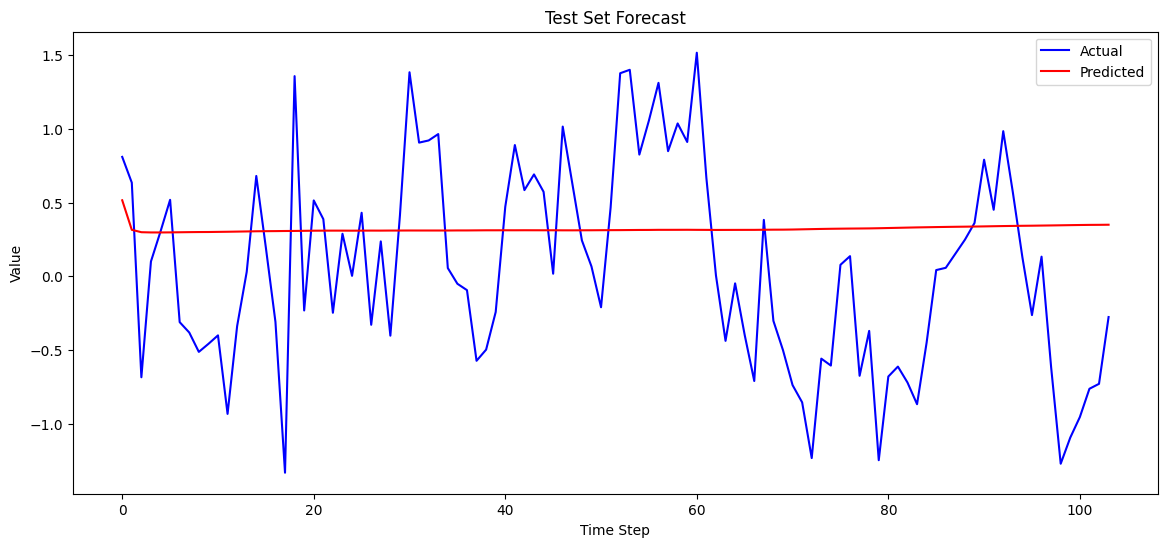

In [37]:
import matplotlib.pyplot as plt

# Plotting the first feature as an example
plt.figure(figsize=(14, 6))
plt.plot(test_data[:, 1], label='Actual', color='blue')  # Adjust index if targeting a different feature
plt.plot(predictions[:, 1], label='Predicted', color='red')  # Adjust indices accordingly
plt.title('Test Set Forecast')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()
